<a href="https://colab.research.google.com/github/Vaani64/Click-Through-Rate-in-Twitch-Streaming/blob/main/bda_proj_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Data

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("volodymyrpivoshenko/twitch-live-streaming-interactions-dataset")

print("Path to dataset files:", path)

#Spark Session

In [ ]:
pip install pyspark

In [ ]:
from pyspark.sql.functions import unix_timestamp, col, lpad, date_format, concat, lit, expr
from pyspark.sql import Column
from pyspark.sql.types import TimestampType

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Twitch Clicks Analysis") \
    .getOrCreate()

In [ ]:
data = spark.read.csv("/content/sample_data/100k_a.csv", header=False, inferSchema=True)
# data = spark.read.csv("/root/.cache/kagglehub/datasets/volodymyrpivoshenko/twitch-live-streaming-interactions-dataset/versions/1/full_a.csv", header=True, inferSchema=True)
data.show(5)

+---+-----------+---------+---+---+
|_c0|        _c1|      _c2|_c3|_c4|
+---+-----------+---------+---+---+
|  1|33842865744| mithrain|154|156|
|  1|33846768288|    alptv|166|169|
|  1|33886469056| mithrain|587|588|
|  1|33887624992|     wtcn|589|591|
|  1|33890145056|jrokezftw|591|594|
+---+-----------+---------+---+---+
only showing top 5 rows



In [ ]:
data = data.toDF("User ID", "Stream ID", "Streamer Username", "Time Start", "Time Stop")
data.show(5)

+-------+-----------+-----------------+----------+---------+
|User ID|  Stream ID|Streamer Username|Time Start|Time Stop|
+-------+-----------+-----------------+----------+---------+
|      1|33842865744|         mithrain|       154|      156|
|      1|33846768288|            alptv|       166|      169|
|      1|33886469056|         mithrain|       587|      588|
|      1|33887624992|             wtcn|       589|      591|
|      1|33890145056|        jrokezftw|       591|      594|
+-------+-----------+-----------------+----------+---------+
only showing top 5 rows



In [ ]:
def to_time(time):
  hours = ((time * 10) / 60).cast("int")
  hours = lpad(hours.cast("string"), 2, "0")
  minutes = (time * 10) % 60
  minutes = lpad(minutes.cast("string"), 2, "0")
  timestamp = concat(hours, lit(":"), minutes)
  return timestamp

In [ ]:
from pyspark.sql.functions import col, unix_timestamp, lit, expr
from pyspark.sql.types import TimestampType

start_reference_time = "2021-08-01 00:00:00"

def to_timestamp(time):
    # Calculate timespan in seconds (10 minutes per unit)
    timespan = time * 10 * 60
    # Add timespan to the reference time, creating a timestamp
    return unix_timestamp(lit(start_reference_time), "yyyy-MM-dd HH:mm:ss") + (timespan)

data = data.withColumn("Start Time", (to_timestamp(col("Time Start")).cast(TimestampType())))
data = data.withColumn("End Time", (to_timestamp(col("Time Stop")).cast(TimestampType())))


In [ ]:
data.show(5)

+-------+-----------+-----------------+----------+---------+-------------------+-------------------+
|User ID|  Stream ID|Streamer Username|Time Start|Time Stop|         Start Time|           End Time|
+-------+-----------+-----------------+----------+---------+-------------------+-------------------+
|      1|33842865744|         mithrain|       154|      156|2021-08-02 01:40:00|2021-08-02 02:00:00|
|      1|33846768288|            alptv|       166|      169|2021-08-02 03:40:00|2021-08-02 04:10:00|
|      1|33886469056|         mithrain|       587|      588|2021-08-05 01:50:00|2021-08-05 02:00:00|
|      1|33887624992|             wtcn|       589|      591|2021-08-05 02:10:00|2021-08-05 02:30:00|
|      1|33890145056|        jrokezftw|       591|      594|2021-08-05 02:30:00|2021-08-05 03:00:00|
+-------+-----------+-----------------+----------+---------+-------------------+-------------------+
only showing top 5 rows



In [ ]:
interaction_volume = data.groupBy("Start Time") \
    .count() \
    .withColumnRenamed("count", "Total Interactions") \
    .orderBy("Start Time")

interaction_volume.show(10)

+-------------------+------------------+
|         Start Time|Total Interactions|
+-------------------+------------------+
|               NULL|                 1|
|2021-08-01 00:00:00|              1033|
|2021-08-01 00:10:00|               448|
|2021-08-01 00:20:00|               269|
|2021-08-01 00:30:00|               313|
|2021-08-01 00:40:00|               237|
|2021-08-01 00:50:00|               238|
|2021-08-01 01:00:00|               247|
|2021-08-01 01:10:00|               162|
|2021-08-01 01:20:00|               205|
+-------------------+------------------+
only showing top 10 rows



In [ ]:
streamer_popularity = data.groupBy("Streamer username") \
    .count() \
    .withColumnRenamed("count", "Total Interactions") \
    .orderBy("Total Interactions", ascending=False)

streamer_popularity.show(10)

+-----------------+------------------+
|Streamer username|Total Interactions|
+-----------------+------------------+
|            ninja|             15113|
|             tfue|             13438|
|           shroud|              8619|
|        riotgames|              5452|
|        nickmercs|              4628|
|       sodapoppin|              4602|
|          dakotaz|              4554|
|         esl_csgo|              4190|
|        asmongold|              4133|
|     timthetatman|              4128|
+-----------------+------------------+
only showing top 10 rows



In [ ]:
data = data.withColumn("Engagement Duration", col("End Time").cast("long") - col("Start Time").cast("long"))

user_retention = data.groupBy("User ID") \
    .avg("Engagement Duration") \
    .withColumnRenamed("avg(Engagement Duration)", "Avg Engagement Duration")

user_retention.show(10)


+-------+-----------------------+
|User ID|Avg Engagement Duration|
+-------+-----------------------+
|    148|                 3500.0|
|    463|     2861.5384615384614|
|    471|      1140.983606557377|
|    496|      2764.285714285714|
|    833|                 1050.0|
|   1088|                 1200.0|
|   1238|                 2920.0|
|   1342|                  840.0|
|   1580|     1154.8387096774193|
|   1591|     1341.1764705882354|
+-------+-----------------------+
only showing top 10 rows



In [ ]:
peak_periods = data.groupBy("Start Time") \
    .count() \
    .withColumnRenamed("count", "Total Interactions") \
    .orderBy("Total Interactions", ascending=False)

peak_periods.show(10)


+-------------------+------------------+
|         Start Time|Total Interactions|
+-------------------+------------------+
|2021-08-01 00:00:00|              1033|
|2021-09-08 20:50:00|               694|
|2021-08-09 01:20:00|               633|
|2021-08-16 00:10:00|               557|
|2021-08-13 01:00:00|               481|
|2021-09-05 21:30:00|               475|
|2021-08-02 01:30:00|               475|
|2021-08-08 01:30:00|               464|
|2021-09-03 21:50:00|               451|
|2021-08-14 23:30:00|               449|
+-------------------+------------------+
only showing top 10 rows



In [ ]:
clicks_per_user = data.groupBy("User ID") \
    .count() \
    .withColumnRenamed("count", "Interaction Count") \
    .orderBy("Interaction Count", ascending=False)

clicks_per_user.show(10)


+-------+-----------------+
|User ID|Interaction Count|
+-------+-----------------+
|  17309|              309|
|   9308|              305|
|  17601|              287|
|   7735|              269|
|  16173|              261|
|  13411|              259|
|  20009|              252|
|   6195|              251|
|   7741|              250|
|  12070|              250|
+-------+-----------------+
only showing top 10 rows



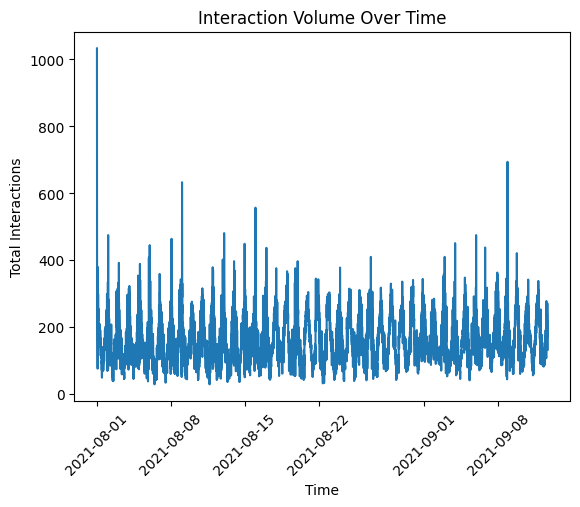

In [ ]:
interaction_volume_pandas = interaction_volume.toPandas()
import matplotlib.pyplot as plt

plt.plot(interaction_volume_pandas['Start Time'], interaction_volume_pandas['Total Interactions'])
plt.xlabel('Time')
plt.ylabel('Total Interactions')
plt.title('Interaction Volume Over Time')
plt.xticks(rotation=45)
plt.show()


In [ ]:
import seaborn as sns

<ipython-input-16-2fe86514f62c>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_streamers, x='Total Interactions', y='Streamer username', palette='coolwarm')


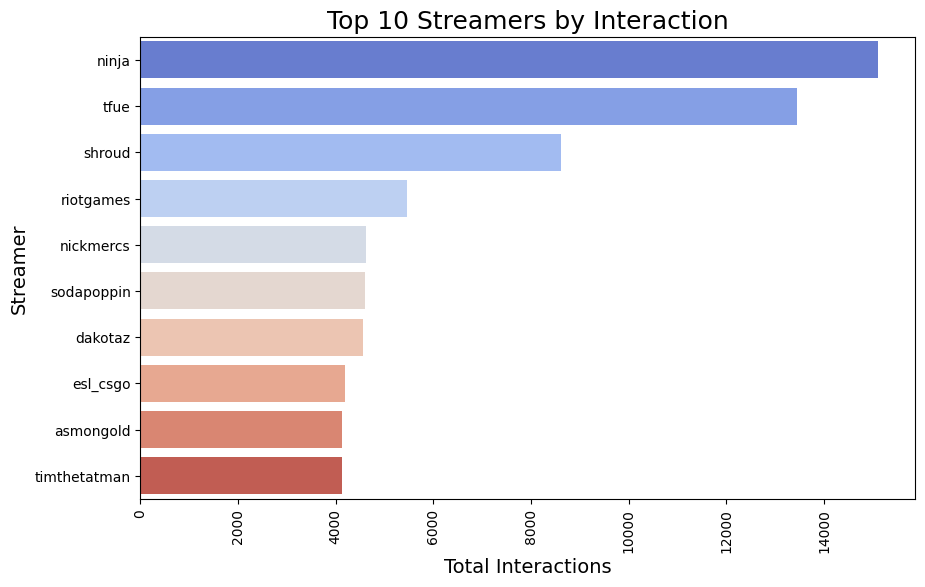

In [ ]:
# Top 10 streamers by interactions
top_streamers = streamer_popularity.toPandas().head(10)

# Create a horizontal bar plot with color gradient
plt.figure(figsize=(10, 6))
sns.barplot(data=top_streamers, x='Total Interactions', y='Streamer username', palette='coolwarm')
plt.title("Top 10 Streamers by Interaction", fontsize=18)
plt.xlabel("Total Interactions", fontsize=14)
plt.ylabel("Streamer", fontsize=14)
plt.xticks(rotation=90)
plt.show()

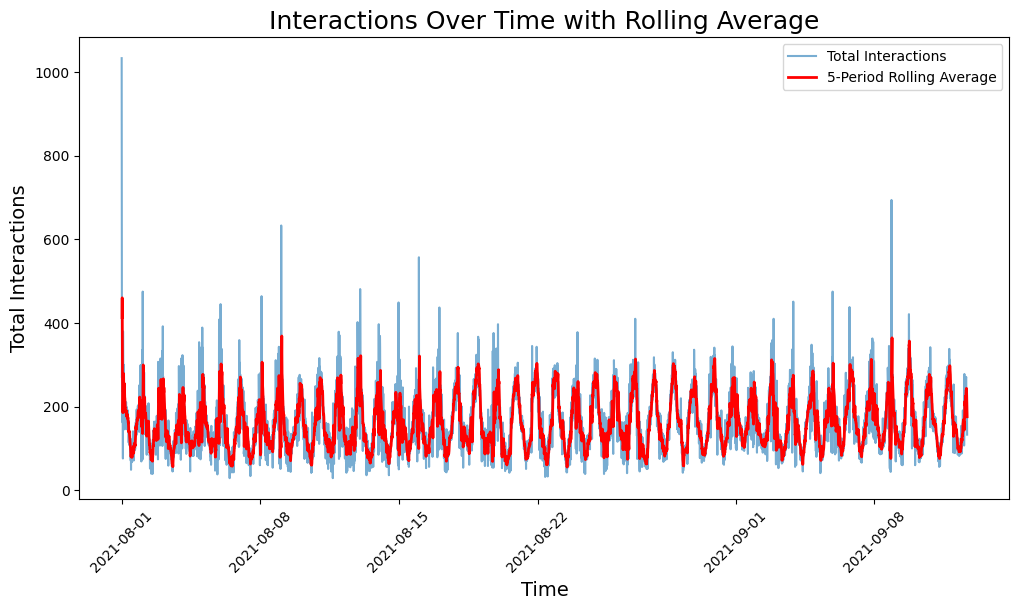

In [ ]:
# Calculate a rolling average (let's say over 5 periods)
interaction_volume_pandas['Rolling Average'] = interaction_volume_pandas['Total Interactions'].rolling(window=5).mean()

plt.figure(figsize=(12, 6))
plt.plot(interaction_volume_pandas['Start Time'], interaction_volume_pandas['Total Interactions'], label='Total Interactions', alpha=0.6)
plt.plot(interaction_volume_pandas['Start Time'], interaction_volume_pandas['Rolling Average'], label='5-Period Rolling Average', color='red', linewidth=2)
plt.title("Interactions Over Time with Rolling Average", fontsize=18)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Total Interactions", fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.show()


<ipython-input-37-13a3fdc07c76>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_users, y='Interaction Count', x='User ID', palette='magma')


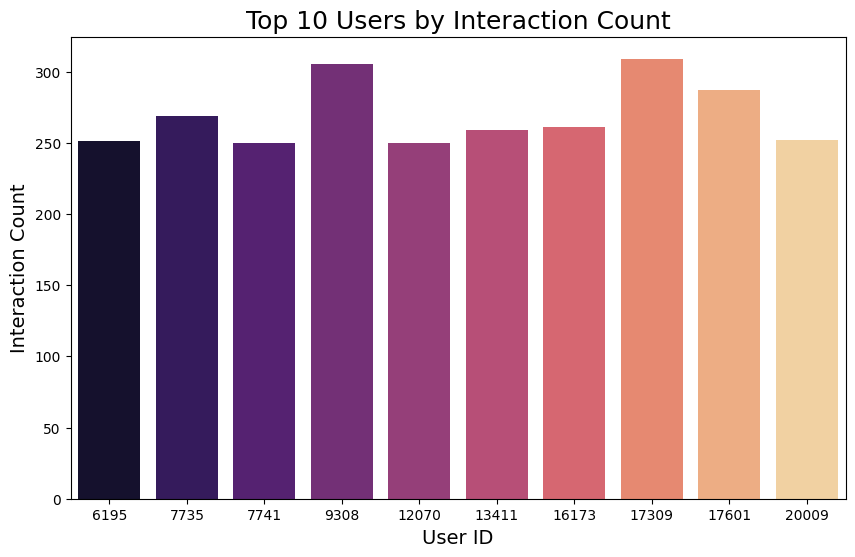

In [ ]:
# Top 10 active users by interaction count
top_users = clicks_per_user.toPandas().head(10)

# Create a bar plot for the top users
plt.figure(figsize=(10, 6))
sns.barplot(data=top_users, y='Interaction Count', x='User ID', palette='magma')
plt.title("Top 10 Users by Interaction Count", fontsize=18)
plt.xlabel("User ID", fontsize=14)
plt.ylabel("Interaction Count", fontsize=14)
plt.show()


In [ ]:
data.show(5)

+-------+-----------+-----------------+----------+---------+-------------------+-------------------+-------------------+
|User ID|  Stream ID|Streamer Username|Time Start|Time Stop|         Start Time|           End Time|Engagement Duration|
+-------+-----------+-----------------+----------+---------+-------------------+-------------------+-------------------+
|      1|33842865744|         mithrain|       154|      156|2021-08-02 01:40:00|2021-08-02 02:00:00|               1200|
|      1|33846768288|            alptv|       166|      169|2021-08-02 03:40:00|2021-08-02 04:10:00|               1800|
|      1|33886469056|         mithrain|       587|      588|2021-08-05 01:50:00|2021-08-05 02:00:00|                600|
|      1|33887624992|             wtcn|       589|      591|2021-08-05 02:10:00|2021-08-05 02:30:00|               1200|
|      1|33890145056|        jrokezftw|       591|      594|2021-08-05 02:30:00|2021-08-05 03:00:00|               1800|
+-------+-----------+-----------

#CNN

In [ ]:
# Sort by 'User ID' and 'Time Start' to maintain chronological order
df = data.orderBy("User ID", "Time Start")

# Display the first few rows to check if sorting is done
df.show(5)

+-------+-----------+-----------------+----------+---------+-------------------+-------------------+-------------------+
|User ID|  Stream ID|Streamer Username|Time Start|Time Stop|         Start Time|           End Time|Engagement Duration|
+-------+-----------+-----------------+----------+---------+-------------------+-------------------+-------------------+
|      1|33842865744|         mithrain|       154|      156|2021-08-02 01:40:00|2021-08-02 02:00:00|               1200|
|      1|33846768288|            alptv|       166|      169|2021-08-02 03:40:00|2021-08-02 04:10:00|               1800|
|      1|33886469056|         mithrain|       587|      588|2021-08-05 01:50:00|2021-08-05 02:00:00|                600|
|      1|33887624992|             wtcn|       589|      591|2021-08-05 02:10:00|2021-08-05 02:30:00|               1200|
|      1|33890145056|        jrokezftw|       591|      594|2021-08-05 02:30:00|2021-08-05 03:00:00|               1800|
+-------+-----------+-----------

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# Create a window partitioned by 'User ID' and ordered by 'Time Start'
window_spec = Window.partitionBy("User ID").orderBy("Time Start")

# Create a new column 'Lagged Engagement Duration' to capture previous interactions
df = df.withColumn("Lag_1", F.lag(df['Engagement Duration'], 1).over(window_spec))
df = df.withColumn("Lag_2", F.lag(df['Engagement Duration'], 2).over(window_spec))
df = df.withColumn("Lag_3", F.lag(df['Engagement Duration'], 3).over(window_spec))

# Drop rows with null values (this will happen for the first `n` rows)
df = df.dropna(subset=["Lag_1", "Lag_2", "Lag_3"])

# Display the new DataFrame with lagged columns
df.show(5)

+-------+-----------+-----------------+----------+---------+-------------------+-------------------+-------------------+-----+-----+-----+
|User ID|  Stream ID|Streamer Username|Time Start|Time Stop|         Start Time|           End Time|Engagement Duration|Lag_1|Lag_2|Lag_3|
+-------+-----------+-----------------+----------+---------+-------------------+-------------------+-------------------+-----+-----+-----+
|      1|33887624992|             wtcn|       589|      591|2021-08-05 02:10:00|2021-08-05 02:30:00|               1200|  600| 1800| 1200|
|      1|33890145056|        jrokezftw|       591|      594|2021-08-05 02:30:00|2021-08-05 03:00:00|               1800| 1200|  600| 1800|
|      1|33903958784|      berkriptepe|       734|      737|2021-08-06 02:20:00|2021-08-06 02:50:00|               1800| 1800| 1200|  600|
|      1|33929318864|  kendinemuzisyen|      1021|     1036|2021-08-08 02:10:00|2021-08-08 04:40:00|               9000| 1800| 1800| 1200|
|      1|33942837056|      

In [ ]:
# Convert the final DataFrame to a Pandas DataFrame
df_pandas = df.select("Lag_1", "Lag_2", "Lag_3", "Engagement Duration").toPandas()

# Convert to NumPy arrays for model input
X = df_pandas[["Lag_1", "Lag_2", "Lag_3"]].values
y = df_pandas["Engagement Duration"].values

# Reshape X to be compatible with CNN (samples, time_steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Define the CNN model
def build_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    # model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1))  # Output layer for regression (continuous value)

    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model

# Define the input shape (time_steps, features)
input_shape = (X.shape[1], 1)  # (time_steps, features)
model = build_cnn_model(input_shape)

# Train the model
model.fit(X, y, epochs=5, batch_size=64)

Epoch 1/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1229.2804
Epoch 2/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1203.4086
Epoch 3/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1194.3574
Epoch 4/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1194.8651
Epoch 5/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1192.5980
Epoch 6/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1197.3367
Epoch 7/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1201.3812
Epoch 8/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1202.7559
Epoch 9/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1194.9761
Epoch 10/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1206.3280


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 1, 64)               │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │           6,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,573 (80.37 KB)

 Trainable params: 6,857 (26.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,716 (53.58 KB)

In [ ]:
# Evaluate the model
loss = model.evaluate(X, y)
print(f"Test Loss (Mean Absolute Error): {loss}")

# Make predictions
predictions = model.predict(X)

# Display the first 5 predictions
for i in range(10):
    print(f"Predicted: {predictions[i]} | Actual: {y[i]}")

2451/2451 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1177.0690
Test Loss (Mean Absolute Error): 1188.73828125
2451/2451 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Predicted: [632.4038] | Actual: 1200
Predicted: [641.58374] | Actual: 1800
Predicted: [652.30914] | Actual: 1800
Predicted: [1099.568] | Actual: 9000
Predicted: [2030.0826] | Actual: 1200
Predicted: [1314.4695] | Actual: 1200
Predicted: [1290.774] | Actual: 1200
Predicted: [1145.1727] | Actual: 600
Predicted: [606.5669] | Actual: 600
Predicted: [585.3683] | Actual: 1200


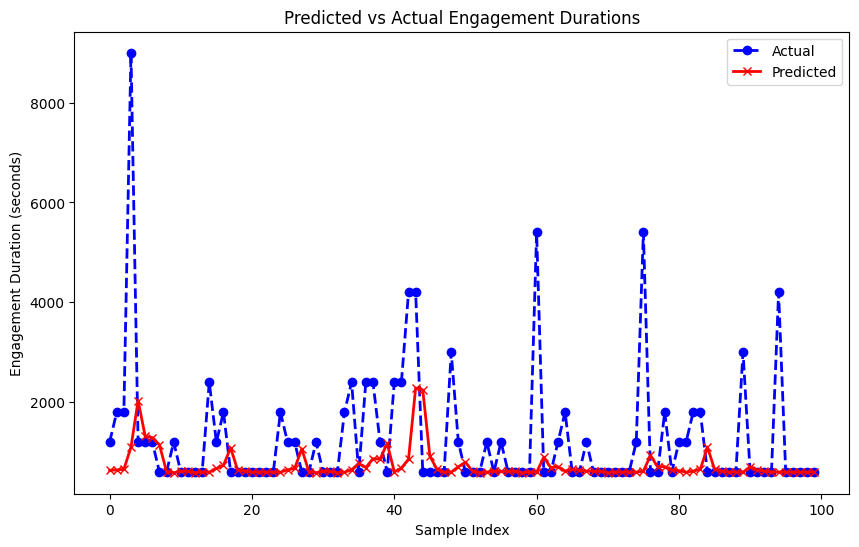

In [ ]:
plt.figure(figsize=(10, 6))

# Plot actual values
plt.plot(y[:100], label='Actual', color='blue', marker='o', linestyle='dashed', linewidth=2)

# Plot predicted values
plt.plot(predictions[:100], label='Predicted', color='red', marker='x', linestyle='solid', linewidth=2)

# Add labels and title
plt.title("Predicted vs Actual Engagement Durations")
plt.xlabel("Sample Index")
plt.ylabel("Engagement Duration (seconds)")

# Display the legend
plt.legend()

# Show the plot
plt.show()

# CTR 3

In [ ]:
impressions_df = data.select("User ID", "Stream ID").distinct().groupBy("Stream ID").count().withColumnRenamed("count", "impressions")
interactions_df = data.filter(data["Engagement Duration"] > 600).groupBy("Stream ID").count().withColumnRenamed("count", "interactions")

ctr_df = impressions_df.join(interactions_df, "Stream ID", "left").fillna(0)
# ctr_df = ctr_df.withColumn("Streamer Username", data["Streamer Username"])
ctr_df = ctr_df.withColumn("CTR", (ctr_df["interactions"] / ctr_df["impressions"]) * 100)

ctr_df.show()

+-----------+-----------+------------+------------------+
|  Stream ID|impressions|interactions|               CTR|
+-----------+-----------+------------+------------------+
|34245553552|          3|           3|             100.0|
|34155018880|          1|           0|               0.0|
|34075929792|          3|           0|               0.0|
|34299056096|         66|          19| 28.78787878787879|
|33938255872|         48|          26|54.166666666666664|
|34390670832|         33|          19| 57.57575757575758|
|34251971536|          2|           0|               0.0|
|34235831600|          2|           1|              50.0|
|33841559136|         13|           6| 46.15384615384615|
|34033655648|         17|           8| 47.05882352941176|
|34199865856|          2|           2|             100.0|
|33833573152|          1|           1|             100.0|
|33886427584|          1|           1|             100.0|
|34244022032|         12|           3|              25.0|
|34357336128| 

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline

# Assuming Stream ID is the primary feature and CTR is the target
vector_assembler = VectorAssembler(inputCols=["impressions", "interactions"], outputCol="features")
ctr_df = ctr_df.withColumnRenamed("CTR", "label")

# Split data
train_data, test_data = ctr_df.randomSplit([0.8, 0.2], seed=42)

# Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="label")

# Random Forest model
rf = RandomForestRegressor(featuresCol="features", labelCol="label")

# Pipeline with both Linear Regression and Random Forest
pipeline_lr = Pipeline(stages=[vector_assembler, lr])
pipeline_rf = Pipeline(stages=[vector_assembler, rf])

# Fit models
model_lr = pipeline_lr.fit(train_data)
model_rf = pipeline_rf.fit(train_data)

# Predictions for Linear Regression
predictions_lr = model_lr.transform(test_data)

# Predictions for Random Forest
predictions_rf = model_rf.transform(test_data)

# Show predictions for both models
print("Linear Regression Predictions:")
predictions_lr.select("Stream ID", "label", "prediction").show()

print("Random Forest Predictions:")
predictions_rf.select("Stream ID", "label", "prediction").show()

In [ ]:
# Compute average actual and predicted CTR for each bin
from pyspark.sql import functions as F

# Compute bin for both LR and RF predictions
bins_lr_df = predictions_lr.withColumn("label_bin", (F.col("label") / 5).cast("int") * 5)  # Bin the actual CTR for aggregation
bins_rf_df = predictions_rf.withColumn("label_bin", (F.col("label") / 5).cast("int") * 5)  # Bin the actual CTR for aggregation

# Aggregate by bins and compute average actual, predicted LR, and predicted RF CTRs
aggregated_lr_df = bins_lr_df.groupBy("label_bin").agg(
    F.avg("label").alias("actual_ctr"),
    F.avg("prediction").alias("predicted_lr_ctr")
).orderBy("label_bin")

aggregated_rf_df = bins_rf_df.groupBy("label_bin").agg(
    F.avg("label").alias("actual_ctr"),
    F.avg("prediction").alias("predicted_rf_ctr")
).orderBy("label_bin")

# Join LR and RF aggregated data
aggregated_df = aggregated_lr_df.join(aggregated_rf_df, on="label_bin", how="outer")

# Collect for plotting
bin_data = aggregated_df.collect()

# Extract data for plotting
labels = [row["label_bin"] for row in bin_data]
actual = [row["actual_ctr"] for row in bin_data]
predicted_lr = [row["predicted_lr_ctr"] for row in bin_data]
predicted_rf = [row["predicted_rf_ctr"] for row in bin_data]

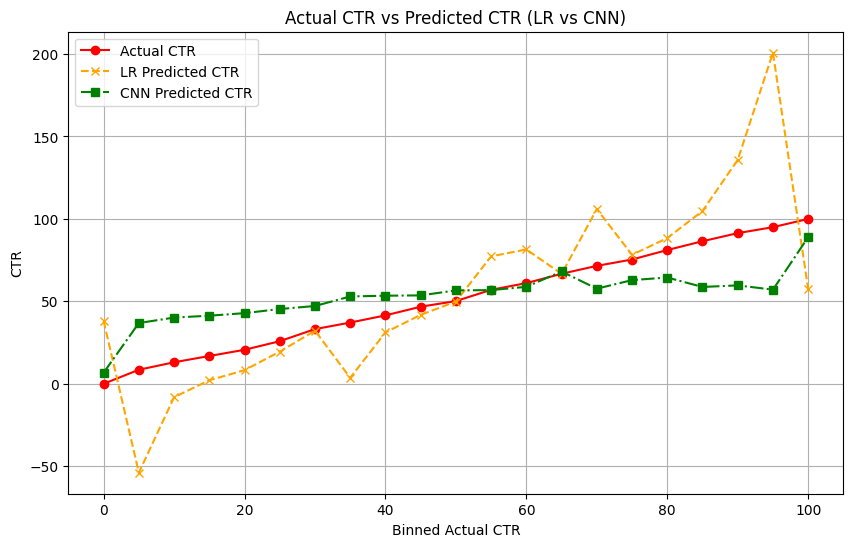

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(labels, actual, label="Actual CTR", color='red', marker='o', linestyle='-')
plt.plot(labels, predicted_lr, label="LR Predicted CTR", color='orange', marker='x', linestyle='--')
plt.plot(labels, predicted_rf, label="CNN Predicted CTR", color='green', marker='s', linestyle='-.')

plt.xlabel("Binned Actual CTR")
plt.ylabel("CTR")
plt.title("Actual CTR vs Predicted CTR (LR vs CNN)")
plt.legend()
plt.grid(True)
plt.show()

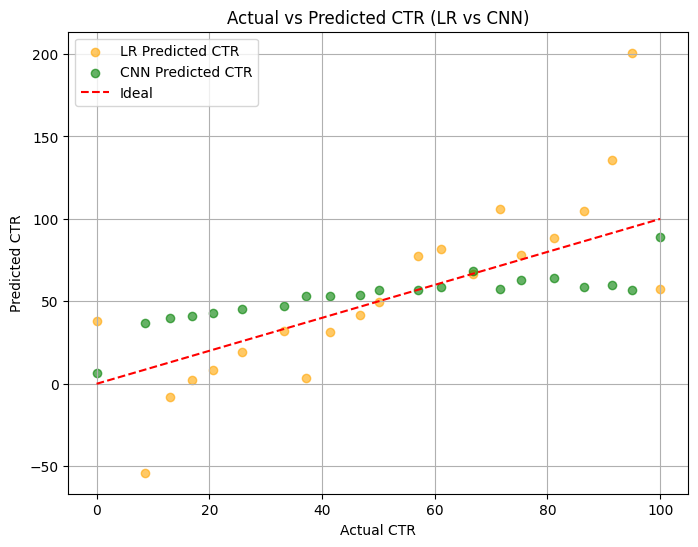

In [ ]:
plt.figure(figsize=(8, 6))

# Scatter plot for LR predictions
plt.scatter(actual, predicted_lr, alpha=0.6, color='orange', label="LR Predicted CTR")

# Scatter plot for RF predictions
plt.scatter(actual, predicted_rf, alpha=0.6, color='green', label="CNN Predicted CTR")

# Ideal line (where Actual = Predicted)
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--', label="Ideal")

# Labels and title
plt.xlabel("Actual CTR")
plt.ylabel("Predicted CTR")
plt.title("Actual vs Predicted CTR (LR vs CNN)")

# Show legend
plt.legend()

# Show grid
plt.grid(True)

# Display the plot
plt.show()

In [ ]:
# Show predictions for both models
print("Linear Regression Predictions:")
predictions_lr.select("Stream ID", "label", "prediction").show()

print("CNN Predictions:")
predictions_rf.select("Stream ID", "label", "prediction").show()

Linear Regression Predictions:
+-----------+------------------+------------------+
|  Stream ID|             label|        prediction|
+-----------+------------------+------------------+
|33802960400|             100.0| 56.04440632057305|
|33811421488|             100.0| 56.04440632057305|
|33813067344|              25.0| 32.43217553477212|
|33823240912|14.285714285714285| 8.819944748971196|
|33823432576|               0.0| 39.69387228902507|
|33823608064|               0.0| 39.69387228902507|
|33824244128| 45.45454545454545|42.739106494095196|
|33824437872|               0.0|  31.8231286937581|
|33824691184|               0.0| 39.69387228902507|
|33824795984|             100.0| 56.04440632057305|
|33824803504|               0.0| 39.69387228902507|
|33824869104|               0.0| 39.69387228902507|
|33824910144|              50.0| 48.17366272530607|
|33825071040|               0.0| 39.69387228902507|
|33825207632|               0.0| 39.69387228902507|
|33825461136|              50.0| 